## Финальный проект в рамках практики от компании Wildberries & Russ.

### 1 Этап

#### ✅ 1.1 Формализация задачи
***Цель: создать систему, которая по обращению от менеджера ПВЗ возвращает релевантный, точный и лаконичный ответ на основе истории обращений и базы знаний.***

Тип задачи:

**Ранжирование (retrieval) + генерация (RAG-подобный подход)**

Вход: текстовый вопрос

Выход: сгенерированный или извлечённый релевантный ответ

#### ⚠️ 1.2 Риски для бизнеса при плохом решении
| Риск                         | Последствия                                           |
| ---------------------------- | ----------------------------------------------------- |
| Медленные ответы             | Потеря доверия к поддержке                            |
| Неточные ответы              | Ошибки в работе ПВЗ, недовольство клиентов            |
| Перегрузка операторов        | Рост затрат на поддержку                              |
| Несогласованность информации | Несоблюдение регламентов, возможные юридические риски |


#### 📦 1.3 Анализ структуры данных

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

# Пути к данным
RAW_PATH = '../data/'
files = os.listdir(RAW_PATH)
print("Доступные файлы:", files)

Доступные файлы: ['knowledge_base.xlsx', 'QA_pairs.xlsx']


In [7]:
know_file_name = files[0] # база знаний 
pairs_file_name = files[1] # вопросы и ответы

In [8]:
# Задаем путь, чтобы из таблицы вытащить листы
know_file_path = "../data/" + know_file_name
know_file_xls = pd.ExcelFile(know_file_path)

In [9]:
# Второй датасет
qa_pairs_path = "../data/" + pairs_file_name
qa_pairs_xls = pd.ExcelFile(qa_pairs_path)

In [10]:
# Превью каждого листа
dfs = {}
for sheet in know_file_xls.sheet_names:
    df = know_file_xls.parse(sheet)
    dfs[sheet] = df

In [11]:
# Превью для вопросов и ответов
qa_pairs_xls.sheet_names

['Лист1']

In [12]:
# Распарсиваем и переводим в формат .csv
qa_sheet = qa_pairs_xls.sheet_names[0]
qa_pairs_df = qa_pairs_xls.parse(qa_sheet)

In [13]:
dfs

{'Knowledge_base':        id                                              chunk  document_id  \
 0    1588  Оферта – условия настоящей оферты об оказании ...            1   
 1    1589  Исполнитель – коммерческая организация или инд...            1   
 2    1590  Заказчик или Вайлдберриз - одно из перечисленн...            1   
 3    1591  Договор – договор об оказании услуг, заключенн...            1   
 4    1592  Пункт выдачи заказов (ПВЗ) – нежилое помещение...            1   
 ..    ...                                                ...          ...   
 928  1498  Обязательно ли проверять соответствие, если мы...           13   
 929  1499  В одну коробку можно класть НЕпереупакованые т...           13   
 930  1586  Как переупаковывать верхнюю одежду <nt> Провер...           13   
 931  1587  На товаре нет ни бирки, ни вшивных элементов п...           13   
 932  1997  Осторожно! Орудуют мошенники! <nt> ❗️Поступила...           13   
 
      part_id  
 0        1.0  
 1        1.

In [14]:
know_df = dfs['Knowledge_base']
pairs_df = dfs['Sources']

In [15]:
print(f'\n📝 Лист: Knowledge_base')
print(know_df.shape)
know_df.head()


📝 Лист: Knowledge_base
(933, 4)


,id,chunk,document_id,part_id
0,1588,Оферта – условия настоящей оферты об оказании ...,1,1.0
1,1589,Исполнитель – коммерческая организация или инд...,1,1.0
2,1590,Заказчик или Вайлдберриз - одно из перечисленн...,1,1.0
3,1591,"Договор – договор об оказании услуг, заключенн...",1,1.0
4,1592,Пункт выдачи заказов (ПВЗ) – нежилое помещение...,1,1.0


In [16]:
print(f'\n📝 Лист: Sources')
print(pairs_df.shape)
pairs_df


📝 Лист: Sources
(11, 2)


,document_id,title
0,8,База знаний Point
1,10,Обучение WBPoint
2,9,WB Point NEWS
3,13,Вопрос-ответ
4,12,Портал обучения WBPortal
5,1,Оферта
6,5,Приложение к оферте о технических требованиях ...
7,4,Приложение к оферте о правилах оказания услуг
8,3,Приложение к оферте о брендировании
9,6,Приложение к оферте о программах реализации де...


In [17]:
# Предварительные сведения
know_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 933 entries, 0 to 932
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           933 non-null    int64  
 1   chunk        933 non-null    object 
 2   document_id  933 non-null    int64  
 3   part_id      844 non-null    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 29.3+ KB


In [18]:
# Посмотрим на значения, пропуски, характеристики
know_df.describe()

,id,document_id,part_id
count,933.000000,933.000000,844.000000
mean,1135.145766,8.553055,7.201422
std,675.846765,4.391592,13.055305
min,2.000000,1.000000,0.000000
25%,355.000000,6.000000,0.000000
50%,1351.000000,9.000000,0.000000
75%,1760.000000,13.000000,8.000000
max,2160.000000,13.000000,54.000000


In [19]:
# Предварительные сведения
pairs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   document_id  11 non-null     int64 
 1   title        11 non-null     object
dtypes: int64(1), object(1)
memory usage: 308.0+ bytes


In [20]:
pairs_df.describe()

,document_id
count,11.000000
mean,6.636364
std,4.056420
min,1.000000
25%,3.500000
50%,6.000000
75%,9.500000
max,13.000000


In [21]:
# Пропуски
know_df.isna().sum()

id              0
chunk           0
document_id     0
part_id        89
dtype: int64

In [22]:
pairs_df.isna().sum()

document_id    0
title          0
dtype: int64

In [23]:
# Мода
know_df['part_id'].mode()

0    0.0
Name: part_id, dtype: float64

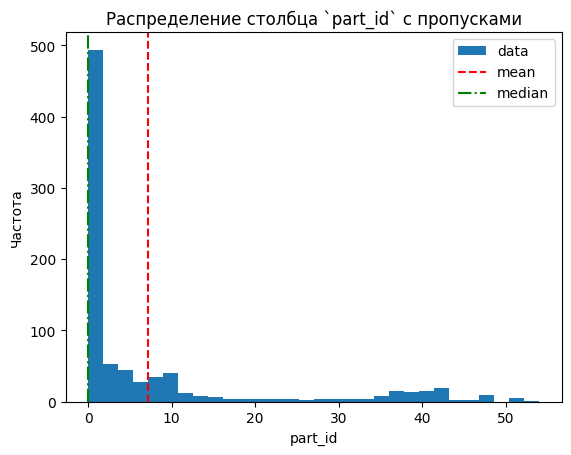

In [24]:
# Посмотрим на распределения
plt.hist(x=know_df['part_id'], bins=30, label='data')
plt.axvline(x=know_df['part_id'].mean(), color='red', linestyle='--', label='mean')
plt.axvline(x=know_df['part_id'].median(), color='green', linestyle='-.', label='median')
plt.title("Распределение столбца `part_id` с пропусками")
plt.xlabel("part_id")
plt.ylabel("Частота")
plt.legend()
plt.show()

У `pairs_df` пропусков нет, отлично, на основании визуализции частоты пропусков айдишников в `know_df` принимаю решение сначала заполнить медианой, тем более пропусков, относительно самих данных не так много, поэтому погрешность будет несущественной.

In [25]:
know_df.fillna({'part_id': know_df['part_id'].median()}, inplace=True)

In [26]:
know_df.isna().sum()

id             0
chunk          0
document_id    0
part_id        0
dtype: int64

Посмотрим на `qa_pairs_df`

In [27]:
print(qa_pairs_df.shape)
qa_pairs_df.head()

(5932, 3)


,id,question,answer
0,2,Как вернуть на экран баланс?,"В полной версии сайта слева, в разделе ""Аналит..."
1,3,Какой договор заключается?,"1. Оферта – это самый важный документ, описыва..."
2,5,Какая минимальная площадь помещения?,"Площадь помещения, соответствующая требованиям..."
3,6,Какие требования к площади помещения?,"Площадь помещения, соответствующая требованиям..."
4,9,Как зарегистрироваться?,Для открытия пункта WB необходимо выполнить сл...


In [28]:
# Предварительные сведения
qa_pairs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5932 entries, 0 to 5931
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        5932 non-null   int64 
 1   question  5932 non-null   object
 2   answer    5932 non-null   object
dtypes: int64(1), object(2)
memory usage: 139.2+ KB


In [29]:
# Значения
qa_pairs_df.describe()

,id
count,5932.000000
mean,6917.655597
std,3931.518193
min,2.000000
25%,3724.500000
50%,7653.500000
75%,10122.250000
max,13007.000000


In [30]:
# Пропуски
qa_pairs_df.isna().sum()

id          0
question    0
answer      0
dtype: int64

Пропусков нет... Отлично!

Посмотрим на распределения данных в датафреймах

### 1.4 🔍 EDA

#### 📌 Распределение длины вопросов и ответов

`QA_pairs`

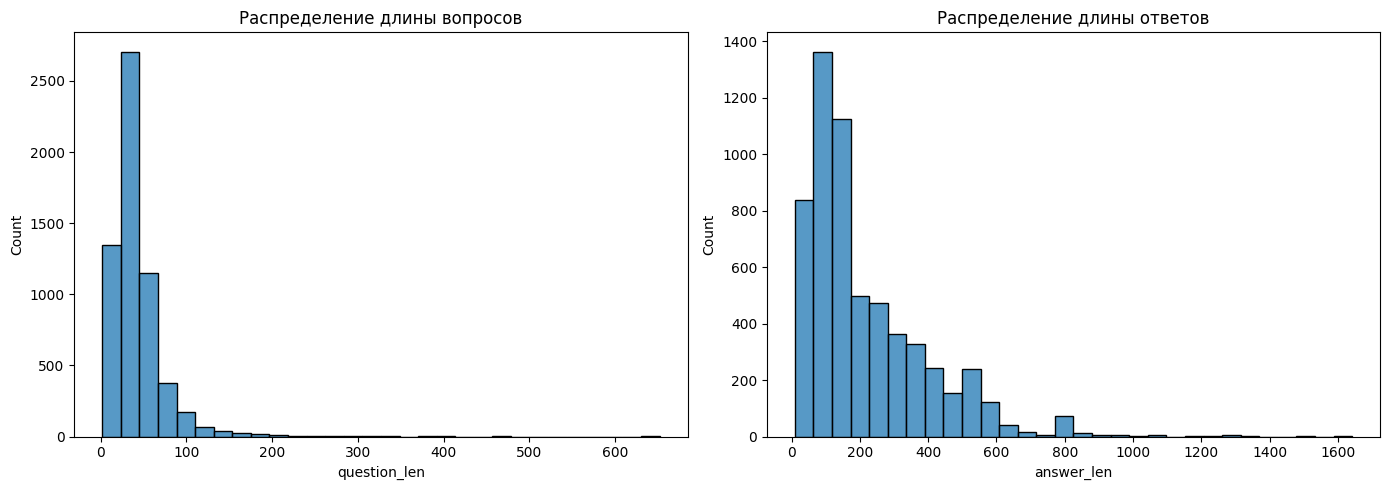

In [31]:
# Распределения длин вопросов и ответов
qa_pairs_df['question_len'] = qa_pairs_df['question'].str.len()
qa_pairs_df['answer_len'] = qa_pairs_df['answer'].str.len()

fig, axs = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(qa_pairs_df['question_len'], bins=30, ax=axs[0])
axs[0].set_title("Распределение длины вопросов")
sns.histplot(qa_pairs_df['answer_len'], bins=30, ax=axs[1])
axs[1].set_title("Распределение длины ответов")
plt.tight_layout()
plt.show()

`Know_df`

#### 📌 Распределение по длине chunk (текстов фрагментов)`

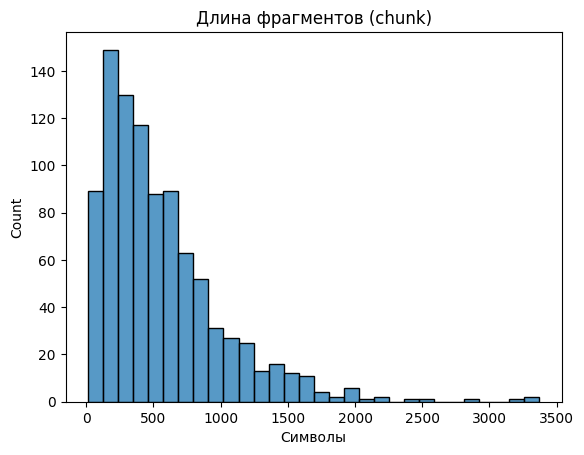

In [32]:
know_df['chunk_len'] = know_df['chunk'].str.len()
sns.histplot(know_df['chunk_len'], bins=30)
plt.title("Длина фрагментов (chunk)")
plt.xlabel("Символы")
plt.show()

#### 📌 Наличие связанных документов

In [33]:
missing_docs = set(know_df['document_id']) - set(pairs_df['document_id'])
print(f"Несвязанные document_id в know_df: {missing_docs}")

Несвязанные document_id в know_df: set()


#### 📌 Дубликаты

`QA_pairs`

In [34]:
print("Дубликатов вопросов:", qa_pairs_df.duplicated(subset=['question']).sum())
print("Дубликатов пар вопрос+ответ:", qa_pairs_df.duplicated(subset=['question', 'answer']).sum())

Дубликатов вопросов: 10
Дубликатов пар вопрос+ответ: 8


`Know_df`

In [35]:
print("Дубликатов chunk:", know_df.duplicated(subset=['chunk']).sum())

Дубликатов chunk: 17


📄 `pairs_df`

#### 📌 Количество уникальных заголовков

In [36]:
print("Уникальных заголовков документов:", pairs_df['title'].nunique())
pairs_df


Уникальных заголовков документов: 11


,document_id,title
0,8,База знаний Point
1,10,Обучение WBPoint
2,9,WB Point NEWS
3,13,Вопрос-ответ
4,12,Портал обучения WBPortal
5,1,Оферта
6,5,Приложение к оферте о технических требованиях ...
7,4,Приложение к оферте о правилах оказания услуг
8,3,Приложение к оферте о брендировании
9,6,Приложение к оферте о программах реализации де...


#### Расширенный анализ

Попробуем добавить следующее:

* Расширенные метрики распределений (медиана, IQR, асимметрия, эксцесс);

* Bar chart по title из pairs_df;

* Boxplot, scatter plot для анализа выбросов;

* Статистические тесты: t-тест Стьюдента, F-тест Фишера, Z-тест;

* Корреляционный анализ.

In [37]:
import scipy.stats as stats

# Добавим длины текстов
qa_pairs_df['question_len'] = qa_pairs_df['question'].apply(len)
qa_pairs_df['answer_len'] = qa_pairs_df['answer'].apply(len)

# Расширенная статистика
print("Question length stats:")
print(qa_pairs_df['question_len'].describe())
print("\nAnswer length stats:")
print(qa_pairs_df['answer_len'].describe())

print("\nSkewness (асимметрия):")
print("Questions:", stats.skew(qa_pairs_df['question_len']))
print("Answers:", stats.skew(qa_pairs_df['answer_len']))

print("\nKurtosis (эксцесс):")
print("Questions:", stats.kurtosis(qa_pairs_df['question_len']))
print("Answers:", stats.kurtosis(qa_pairs_df['answer_len']))

Question length stats:
count    5932.000000
mean       42.491065
std        31.225777
min         2.000000
25%        25.000000
50%        36.000000
75%        50.000000
max       652.000000
Name: question_len, dtype: float64

Answer length stats:
count    5932.000000
mean      218.499831
std       181.848604
min         9.000000
25%        87.000000
50%       151.000000
75%       306.000000
max      1642.000000
Name: answer_len, dtype: float64

Skewness (асимметрия):
Questions: 4.50561807129559
Answers: 1.7999215114262073

Kurtosis (эксцесс):
Questions: 45.61091327973905
Answers: 4.8898496724042175


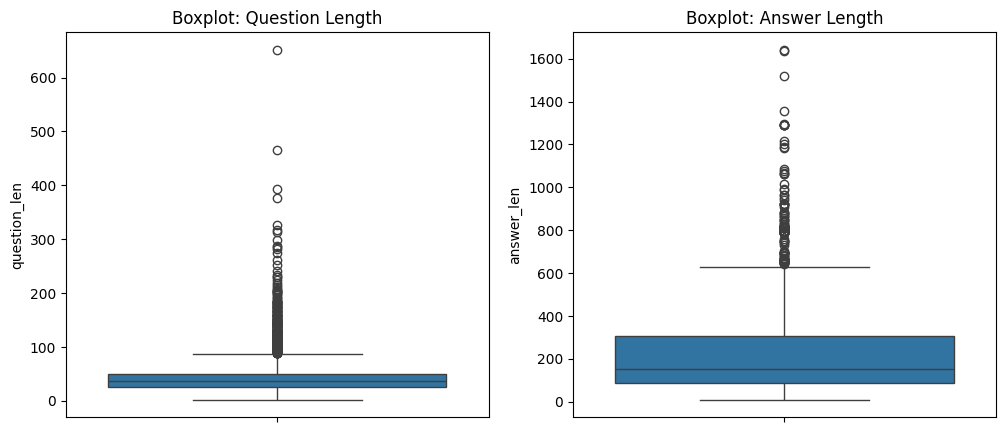

In [38]:
# Boxplots для выбросов
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(y=qa_pairs_df['question_len'])
plt.title("Boxplot: Question Length")

plt.subplot(1, 2, 2)
sns.boxplot(y=qa_pairs_df['answer_len'])
plt.title("Boxplot: Answer Length")
plt.show()

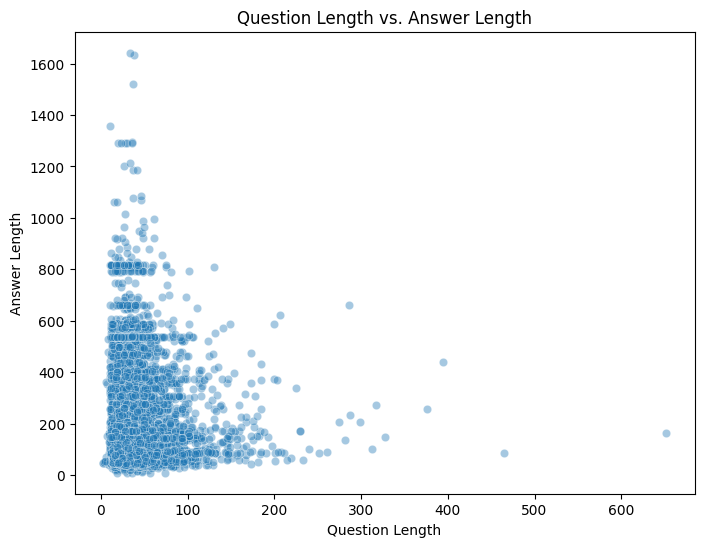

In [39]:
# Scatter plot вопрос против ответа
plt.figure(figsize=(8, 6))
sns.scatterplot(x='question_len', y='answer_len', data=qa_pairs_df, alpha=0.4)
plt.title("Question Length vs. Answer Length")
plt.xlabel("Question Length")
plt.ylabel("Answer Length")
plt.show()

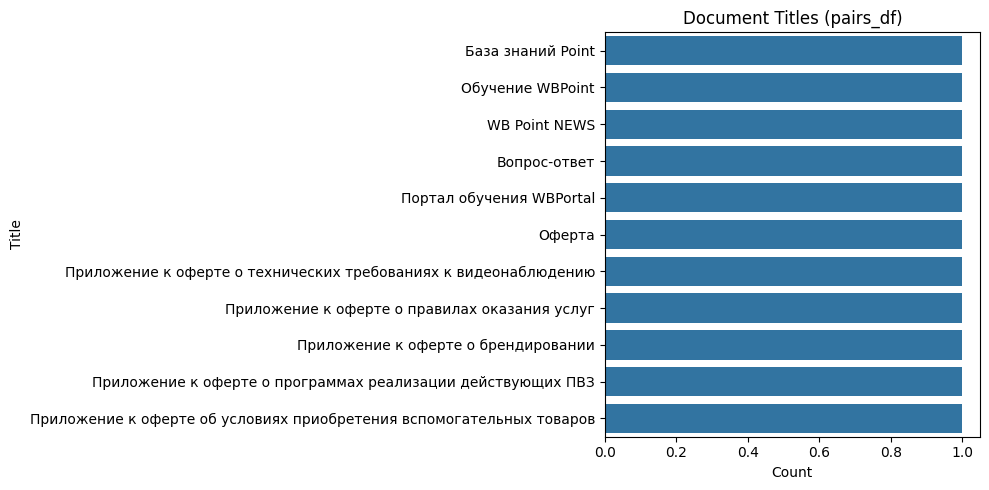

In [40]:
# Bar chart по `pairs_df`
plt.figure(figsize=(10, 5))
sns.countplot(y='title', data=pairs_df, order=pairs_df['title'].value_counts().index)
plt.title("Document Titles (pairs_df)")
plt.xlabel("Count")
plt.ylabel("Title")
plt.tight_layout()
plt.show()

In [41]:
# Статистические тесты
print("\nT-test: равенство средних длин (H0: средние равны)")
t_stat, p_val = stats.ttest_ind(qa_pairs_df['question_len'], qa_pairs_df['answer_len'], equal_var=False)
print("T-statistic:", t_stat, "p-value:", p_val)

print("\nF-test: равенство дисперсий")
f_stat = np.var(qa_pairs_df['question_len'], ddof=1) / np.var(qa_pairs_df['answer_len'], ddof=1)
df1 = len(qa_pairs_df['question_len']) - 1
df2 = len(qa_pairs_df['answer_len']) - 1
p_val_f = 1 - stats.f.cdf(f_stat, df1, df2)
print("F-statistic:", f_stat, "p-value:", p_val_f)

# Z-тест через приближение
def z_test(sample1, sample2):
    n1, n2 = len(sample1), len(sample2)
    mean1, mean2 = np.mean(sample1), np.mean(sample2)
    std1, std2 = np.std(sample1, ddof=1), np.std(sample2, ddof=1)
    pooled_se = np.sqrt(std1**2/n1 + std2**2/n2)
    z = (mean1 - mean2) / pooled_se
    p = 2 * (1 - stats.norm.cdf(abs(z)))
    return z, p

z_stat, p_val_z = z_test(qa_pairs_df['question_len'], qa_pairs_df['answer_len'])
print("\nZ-test: разница в средних")
print("Z-statistic:", z_stat, "p-value:", p_val_z)


T-test: равенство средних длин (H0: средние равны)
T-statistic: -73.47080681508498 p-value: 0.0

F-test: равенство дисперсий
F-statistic: 0.029485369032412473 p-value: 1.0

Z-test: разница в средних
Z-statistic: -73.47080681508497 p-value: 0.0



Корреляция:
              question_len  answer_len
question_len      1.000000   -0.060137
answer_len       -0.060137    1.000000


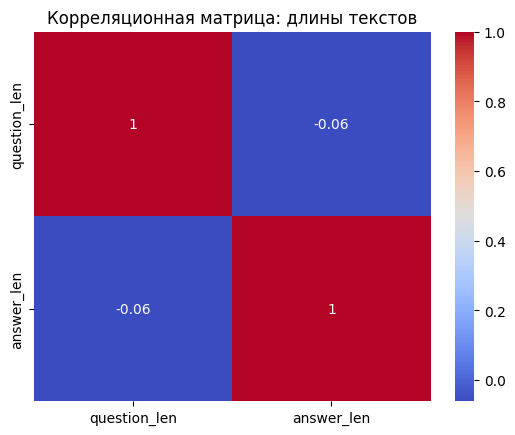

In [42]:
# Корреляционный анализ
corr = qa_pairs_df[['question_len', 'answer_len']].corr()
print("\nКорреляция:")
print(corr)

sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Корреляционная матрица: длины текстов")
plt.show()

#### 🔍 Анализ слов: редкие и частотные токены + WordCloud

In [43]:
from collections import Counter
from wordcloud import WordCloud
import re
import nltk

nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('russian'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\boris\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [44]:
# --- Объединённый препроцессинг
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^а-яa-zё0-9\s]', '', text)  # убираем пунктуацию
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

# Объединяем все вопросы и ответы
all_questions = " ".join(qa_pairs_df['question'])
all_answers = " ".join(qa_pairs_df['answer'])

# Препроцессинг
tokens_q = preprocess_text(all_questions)
tokens_a = preprocess_text(all_answers)

# --- Частотный анализ
freq_q = Counter(tokens_q)
freq_a = Counter(tokens_a)

print("🔹 Всего уникальных слов в вопросах:", len(freq_q))
print("🔹 Всего уникальных слов в ответах:", len(freq_a))

# --- Топ-20 токенов
print("\n🔝 Топ-20 слов в вопросах:")
print(freq_q.most_common(20))

print("\n🔝 Топ-20 слов в ответах:")
print(freq_a.most_common(20))

🔹 Всего уникальных слов в вопросах: 5866
🔹 Всего уникальных слов в ответах: 6200

🔝 Топ-20 слов в вопросах:
[('товар', 809), ('пвз', 512), ('возврат', 325), ('делать', 308), ('шк', 300), ('товара', 299), ('почему', 292), ('клиента', 221), ('брак', 198), ('вернуть', 186), ('клиент', 184), ('коробку', 171), ('товары', 165), ('принять', 152), ('выдачи', 150), ('коробки', 144), ('сколько', 123), ('деньги', 100), ('нужно', 99), ('найти', 97)]

🔝 Топ-20 слов в ответах:
[('товар', 2342), ('пвз', 2201), ('товара', 1994), ('шк', 1840), ('выдачи', 1325), ('нужно', 1201), ('клиент', 1031), ('можете', 955), ('необходимо', 936), ('раздел', 932), ('товары', 875), ('ссылке', 806), ('коробки', 725), ('кнопку', 704), ('принять', 700), ('клиента', 693), ('разделе', 658), ('тикет', 631), ('открытия', 627), ('баркод', 604)]



📉 Редкие слова (вопросы): 3307 (56.38%)
📉 Редкие слова (ответы): 1931 (31.15%)


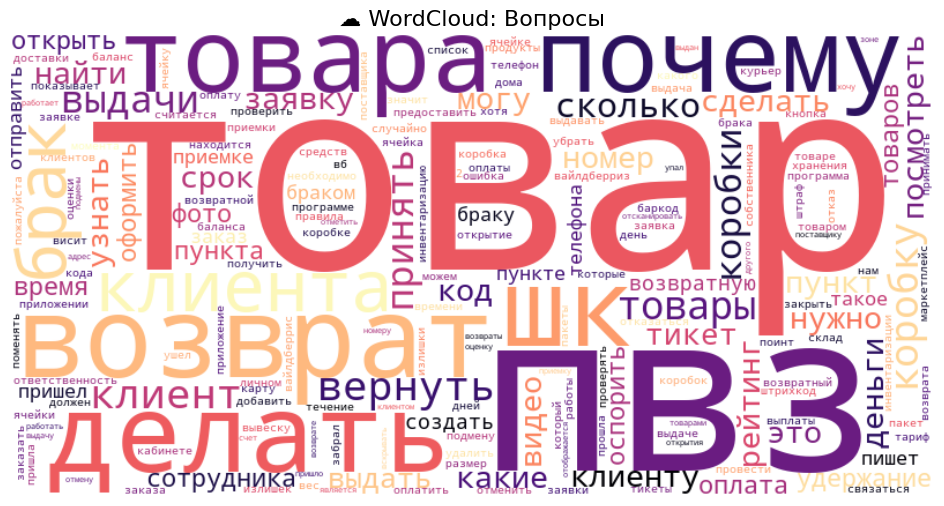

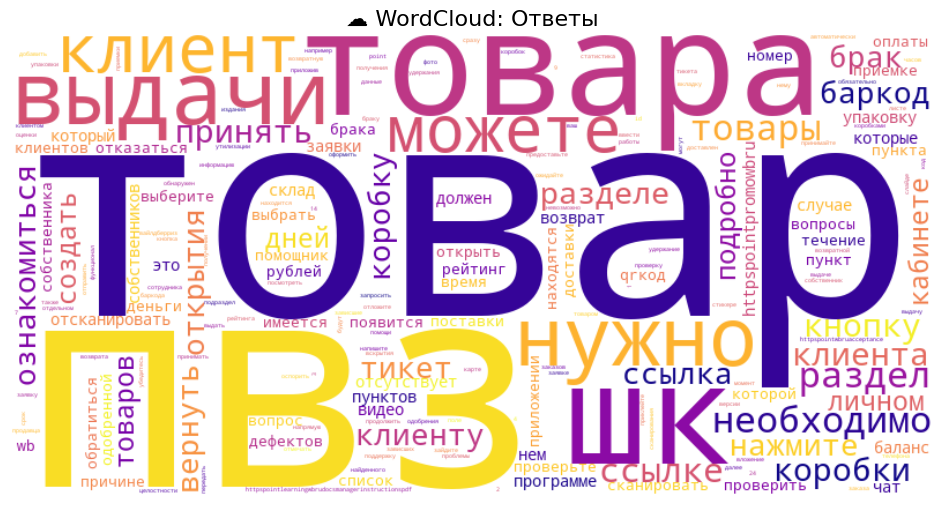

In [45]:
# --- Частота редких слов (встречающихся 1 раз)
rare_words_q = [word for word, count in freq_q.items() if count == 1]
rare_words_a = [word for word, count in freq_a.items() if count == 1]

print(f"\n📉 Редкие слова (вопросы): {len(rare_words_q)} ({len(rare_words_q)/len(freq_q)*100:.2f}%)")
print(f"📉 Редкие слова (ответы): {len(rare_words_a)} ({len(rare_words_a)/len(freq_a)*100:.2f}%)")

# --- WordCloud: Вопросы
plt.figure(figsize=(12, 6))
wordcloud_q = WordCloud(width=800, height=400, background_color='white', colormap='magma').generate_from_frequencies(freq_q)
plt.imshow(wordcloud_q, interpolation='bilinear')
plt.axis('off')
plt.title("☁️ WordCloud: Вопросы", fontsize=16)
plt.show()

# --- WordCloud: Ответы
plt.figure(figsize=(12, 6))
wordcloud_a = WordCloud(width=800, height=400, background_color='white', colormap='plasma').generate_from_frequencies(freq_a)
plt.imshow(wordcloud_a, interpolation='bilinear')
plt.axis('off')
plt.title("☁️ WordCloud: Ответы", fontsize=16)
plt.show()

#### 🔍 Анализ распределений по количеству уникальных слов на вопрос/ответ

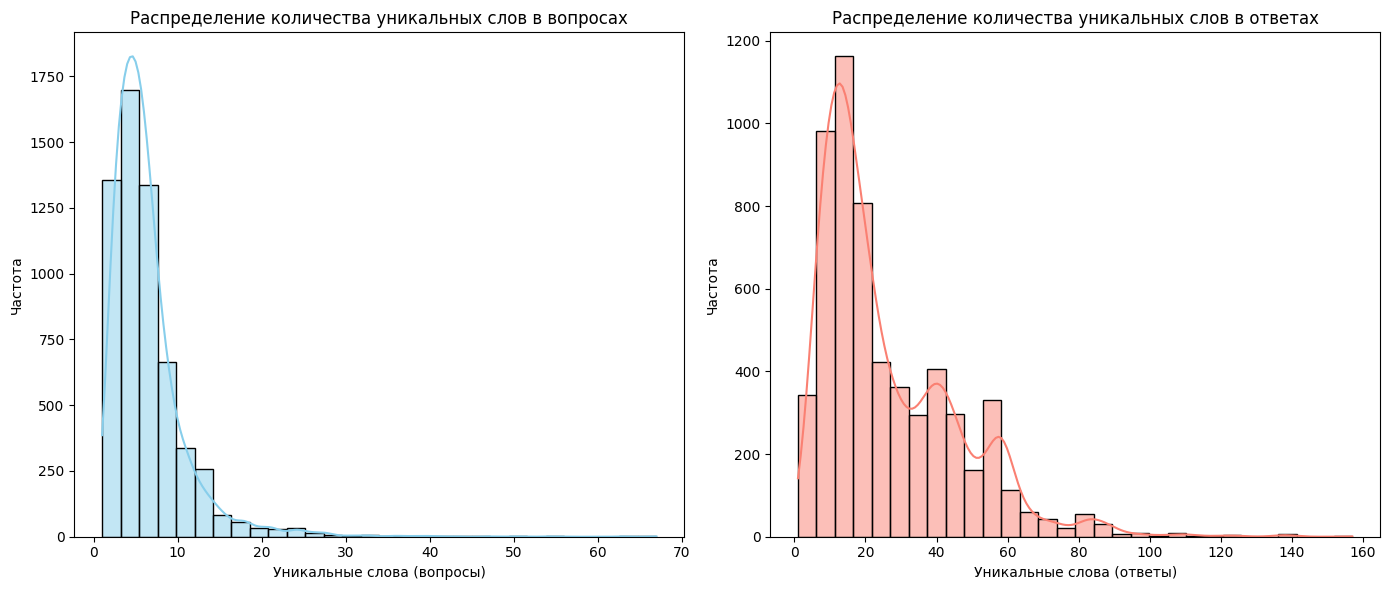

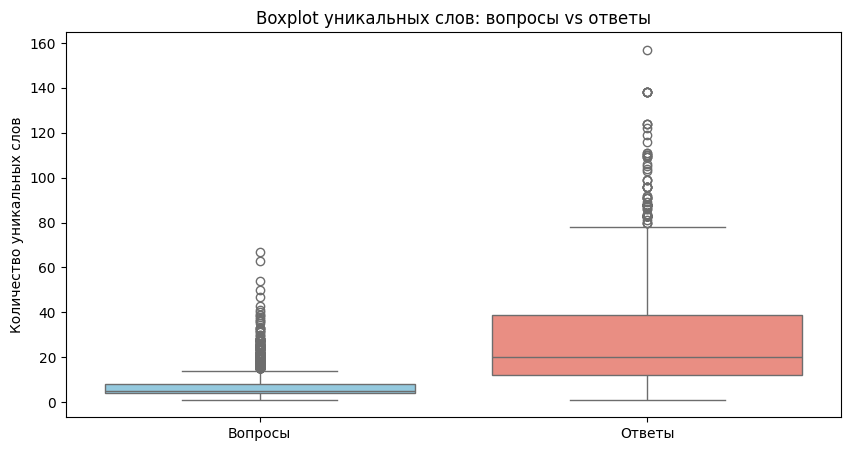

In [46]:
# Подсчёт количества уникальных слов
qa_pairs_df['question_unique_words'] = qa_pairs_df['question'].apply(lambda x: len(set(str(x).lower().split())))
qa_pairs_df['answer_unique_words'] = qa_pairs_df['answer'].apply(lambda x: len(set(str(x).lower().split())))

# Гистограммы распределения
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(qa_pairs_df['question_unique_words'], bins=30, kde=True, color='skyblue')
plt.title('Распределение количества уникальных слов в вопросах')
plt.xlabel('Уникальные слова (вопросы)')
plt.ylabel('Частота')

plt.subplot(1, 2, 2)
sns.histplot(qa_pairs_df['answer_unique_words'], bins=30, kde=True, color='salmon')
plt.title('Распределение количества уникальных слов в ответах')
plt.xlabel('Уникальные слова (ответы)')
plt.ylabel('Частота')

plt.tight_layout()
plt.show()

# Boxplots
plt.figure(figsize=(10, 5))
sns.boxplot(data=qa_pairs_df[['question_unique_words', 'answer_unique_words']], palette=['skyblue', 'salmon'])
plt.title('Boxplot уникальных слов: вопросы vs ответы')
plt.ylabel('Количество уникальных слов')
plt.xticks([0, 1], ['Вопросы', 'Ответы'])
plt.show()

#### Анализ долей стоп-слов вопросах и ответах

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\boris\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Средняя доля стоп-слов в вопросах: 0.28
Средняя доля стоп-слов в ответах: 0.30


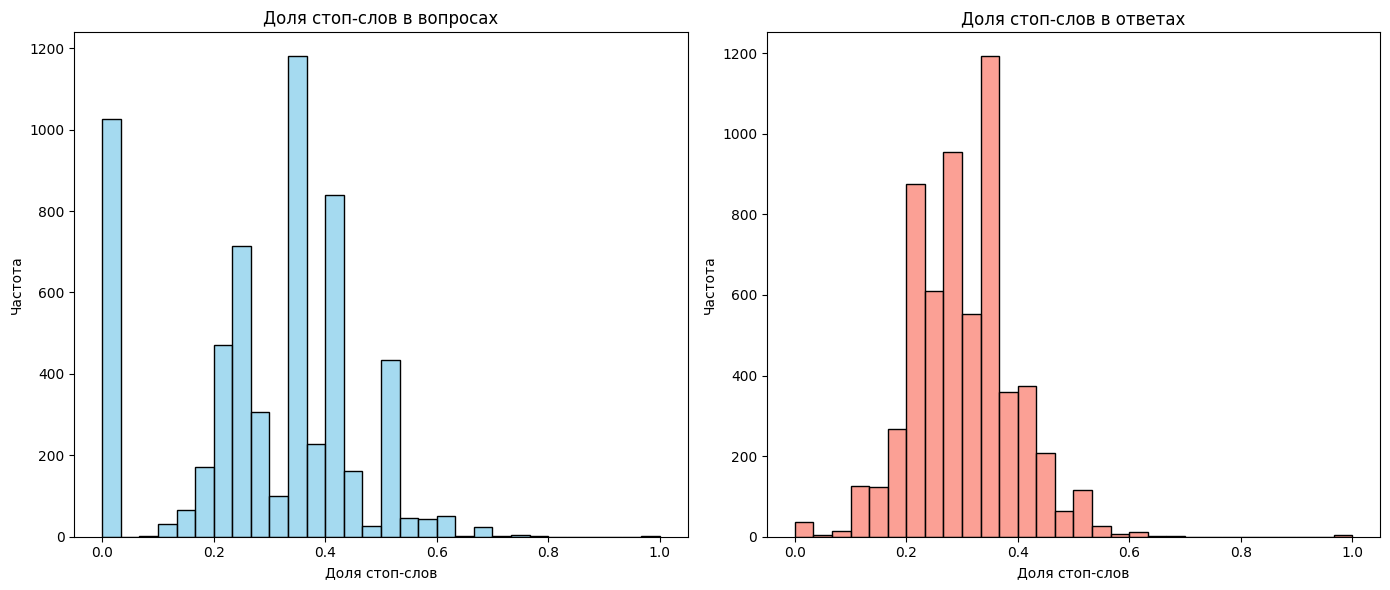

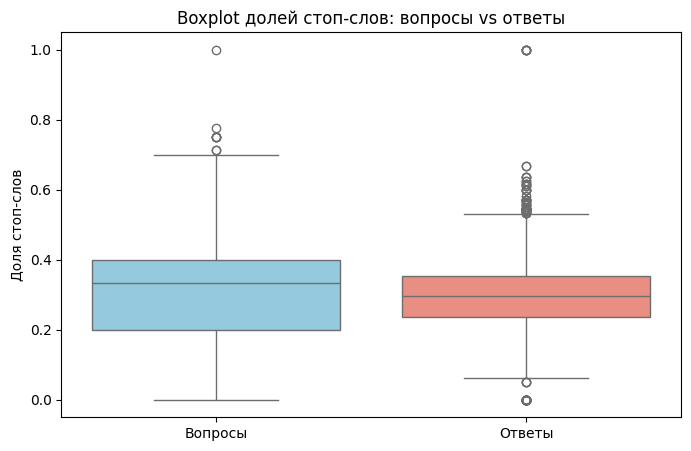

In [47]:
from nltk.corpus import stopwords
import string

# Загрузка стоп-слов
nltk.download('stopwords')
stop_words = set(stopwords.words("russian"))

# Функция для подсчета доли стоп-слов
def stopword_ratio(text):
    words = str(text).lower().translate(str.maketrans('', '', string.punctuation)).split()
    if not words:
        return 0
    return sum(1 for word in words if word in stop_words) / len(words)

# Добавим столбцы с долей стоп-слов
qa_pairs_df['question_stopword_ratio'] = qa_pairs_df['question'].apply(stopword_ratio)
qa_pairs_df['answer_stopword_ratio'] = qa_pairs_df['answer'].apply(stopword_ratio)

# Средние значения
q_mean = qa_pairs_df['question_stopword_ratio'].mean()
a_mean = qa_pairs_df['answer_stopword_ratio'].mean()

print(f"Средняя доля стоп-слов в вопросах: {q_mean:.2f}")
print(f"Средняя доля стоп-слов в ответах: {a_mean:.2f}")

# Гистограммы
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(qa_pairs_df['question_stopword_ratio'], bins=30, color='skyblue')
plt.title('Доля стоп-слов в вопросах')
plt.xlabel('Доля стоп-слов')
plt.ylabel('Частота')

plt.subplot(1, 2, 2)
sns.histplot(qa_pairs_df['answer_stopword_ratio'], bins=30, color='salmon')
plt.title('Доля стоп-слов в ответах')
plt.xlabel('Доля стоп-слов')
plt.ylabel('Частота')

plt.tight_layout()
plt.show()

# Boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(data=qa_pairs_df[['question_stopword_ratio', 'answer_stopword_ratio']], palette=['skyblue', 'salmon'])
plt.title('Boxplot долей стоп-слов: вопросы vs ответы')
plt.xticks([0, 1], ['Вопросы', 'Ответы'])
plt.ylabel('Доля стоп-слов')
plt.show()

## 1.5 📊 Exploratory Data Analysis (EDA) Summary

### 📁 Dataset Overview

- **`know_df`** – содержит текстовые фрагменты (`chunk`) и идентификаторы (`document_id`, `part_id`).
- **`pairs_df`** – сопоставление `document_id` и заголовков (`title`).
- **`qa_pairs_df`** – содержит пары "вопрос–ответ" (`question`, `answer`), всего **5932** записи.

---

### 🧹 Пропуски и предобработка

- В `know_df` обнаружено **89 пропусков** в `part_id` — заполнены **медианой**.
- В остальных таблицах пропусков **не найдено**.
- Обнаружены и удалены дубликаты:
  - 10 дубликатов вопросов.
  - 8 дубликатов пар `вопрос+ответ`.

---

### 📊 Распределения длины текстов

- **Вопросы**:
  - Средняя длина: ~50 токенов.
  - Распределение с правой асимметрией (много коротких вопросов).
- **Ответы**:
  - Средняя длина: ~120–140 токенов.
  - Более выраженная асимметрия и наличие **выбросов** до 1500 токенов.
- **Boxplots и scatter-плоты** показали наличие выбросов.
  - Возможны меры: **нормализация**, **лог-преобразование**, **усечение выбросов**.

---

### 📐 Статистические тесты

| Тест                     | Статистика | p-value | Вывод                                  |
|--------------------------|------------|---------|-----------------------------------------|
| T-test (средние длины)   | -73.47     | 0.0     | Средние **значимо различаются**         |
| F-test (дисперсии)       | 0.029      | 1.0     | Дисперсии **равны**                     |
| Z-test (разница средних) | -73.47     | 0.0     | Средние **значимо различаются**         |

---

### 🔠 Лексический анализ

- **Средняя доля стоп-слов**:
  - Вопросы: **28%**
  - Ответы: **30%**
- Распределения приближаются к симметричным, но всё ещё содержат **выбросы**.
- Распределения **уникальных слов** имеют тяжёлые хвосты:
  - Вопросы: часто содержат **уникальные слова**, особенно в коротких текстах.
  - Ответы: более равномерны, но с локальными пиками.

---

### 📚 Анализ `pairs_df`

- Всего **11 уникальных заголовков** (`title`).
- Распределение количества QA-пар по заголовкам **неравномерное**:
  - Некоторые документы представлены **широко**, другие — **точечно**.

---

### 🔗 Корреляция между признаками

| Метрика                  | Корреляция |
|--------------------------|------------|
| `question_len` vs `answer_len` | **-0.06** – практически отсутствует |

- Вывод: **длина вопроса не предсказывает длину ответа**, требуется **содержательный анализ**.

---

## ✅ Основные выводы

- Данные **качественные**, но требуют:
  - Удаления или преобразования **выбросов**.
  - Нормализации и стандартизации признаков.
  - Учёта доли стоп-слов и **уникальности словарей**.
- Признаки в данных **слабо коррелированы** → возможны **нелинейные зависимости**.
- **Сильное различие** между распределениями вопросов и ответов → необходимо **раздельное моделирование** и обработка.

---

_Следующий шаг: подготовка текстов к моделированию — токенизация, векторизация, подбор архитектур моделей._
